In [111]:
import numpy as np
import pandas as pd
from pyproj import Geod
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import haversine
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from math import sin, cos, sqrt, atan2, radians

In [112]:
train_data = pd.read_csv( "train.csv" )
test_data = pd.read_csv( "test.csv" )

In [113]:
# Utiliy functions

#Get distance between pairs of lat-lon points
wgs84_geod = Geod(ellps='WGS84')
def get_distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
    return dist

In [114]:
def normalize(data):
    return ((data-data.min())/(data.max()-data.min()))


def process_data(data):
    # Calculating distance (m) based on longitude/latituides and adding it in a new column 'dist'
    data['dist'] = get_distance(data['pickup_latitude'].tolist(), data['pickup_longitude'].tolist(),
                                data['dropoff_latitude'].tolist(), data['dropoff_longitude'].tolist())
    
    data['dist'] = data['dist'] / 1000
    data['haversine_distance'] = data.apply(lambda r: haversine.haversine((r['pickup_latitude'],r['pickup_longitude']),
                                                                          (r['dropoff_latitude'], r['dropoff_longitude'])), 
                                                                          axis=1)
    data['manhattan_distance'] = (abs(data.dropoff_longitude - data.pickup_longitude) +
                                  abs(data.dropoff_latitude - data.pickup_latitude))
    
    data['log_distance'] = np.log(data['dist'] + 1)
    data['log_haversine_distance'] = np.log(data['haversine_distance'] + 1)
    data['log_manhattan_distance'] = np.log(data.manhattan_distance + 1)
    
    data['sqr_distance'] = data['log_distance']**2
    data['sqr_haversine_distance'] = data['log_haversine_distance']**2
    data['sqr_manhattan_distance'] = data['log_manhattan_distance']**2
    
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
    data['pickup_minute_of_the_day'] = data.pickup_datetime.dt.hour*60 + data.pickup_datetime.dt.minute
    data['pickup_month'] = data.pickup_datetime.dt.month
  
    data['no_passengers'] = data.passenger_count.map(lambda x: 1 if x == 0 else 0)
    data['one_passenger'] = data.passenger_count.map(lambda x: 1 if x == 1 else 0)
    data['few_passengers'] = data.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
    data['many_passengers'] = data.passenger_count.map(lambda x: 1 if x >= 5 else 0)
    
    data['night_trip'] = [True if x < 7 else False for x in data['pickup_hour']]
    data['rush_hour'] = [True if 9 < x < 20 else False for x in data['pickup_hour']]
    data['weekday'] = [True if x < 5 else False for x in data['pickup_weekday']]
    
    # Replacing N of store_and_fwd_flag with 0 and Y with 1
    data = data.replace({'N': 0, 'Y': 1})
    
    # Dropping columns no longer required
    data = data.drop(['pickup_latitude','pickup_longitude', 'pickup_datetime', 'pickup_weekday',
                      'dropoff_latitude','dropoff_longitude', 'store_and_fwd_flag', 'id'], axis=1)
     
    return data

In [115]:
# Hypothesis function
def hyp(theta, X):
    return np.dot(X, theta.T)  

# The loss function in our case is the sum of the squared error
def loss_func(theta, X, Y):
    return np.sum(((hyp(theta, X) - Y)**2) / (2 * X.shape[0]))

def get_graident(theta, X, Y):
    derivatives = []
  
    for i in range(0, X.shape[1]):
        derivatives.append(np.sum((hyp(theta, X) - Y) * X[:, i]) / X.shape[0])

    return np.array(derivatives)


def gradient_descent(X, Y, maxniter=20000):
    thetas = np.random.rand(X.shape[1],)
    alpha = 0.01
    costs = []
    
    for i in range(0, maxniter):
        thetas = thetas - (alpha * get_graident(thetas, X, Y))
        costs.append(loss_func(thetas, X, Y))
        
    return thetas, costs

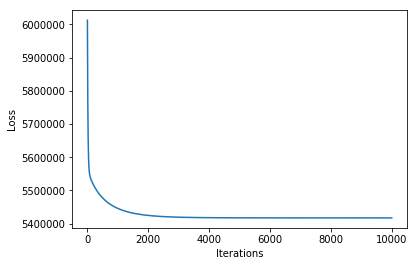

In [116]:
proc_data = process_data(train_data)
X = normalize(proc_data.drop('trip_duration', axis=1)).values
Y = proc_data['trip_duration'].values

max_iters = 10000
thetas, costs = gradient_descent(X, Y, max_iters)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.plot(np.arange(0, max_iters), costs)

In [117]:
pred = hyp(thetas, normalize(process_data(test_data)))
submission = pd.DataFrame({'id':test_data['id'], 'trip_duration':pred})
submission.to_csv("kaggle_submission.csv", index=False)

submission['trip_duration'].describe()

count    30000.000000
mean       983.179321
std        583.174325
min       -300.281609
25%        593.897888
50%        858.586773
75%       1226.518037
max       4799.546860
Name: trip_duration, dtype: float64

In [118]:
# from scipy import stats
# temp = train_data[train_data.trip_duration <= np.percentile(train_data.trip_duration, 99)]

# fig, ax = plt.subplots(2,2,figsize=(20, 10), sharex=False, sharey = False)
# sns.despine(left=True)
# sns.distplot(temp['trip_duration'].values, label = 'pickup_latitude',color="g",bins = 100, ax=ax[0,0])

In [119]:
submission

,id,trip_duration
0,id1430318,975.865561
1,id3276964,551.417695
2,id2541342,1128.051820
3,id3582288,492.000562
4,id2976277,205.473478
5,id1856113,642.631048
6,id0712136,1249.227233
7,id2704634,932.369057
8,id2736446,194.179246
9,id3267520,1002.591805


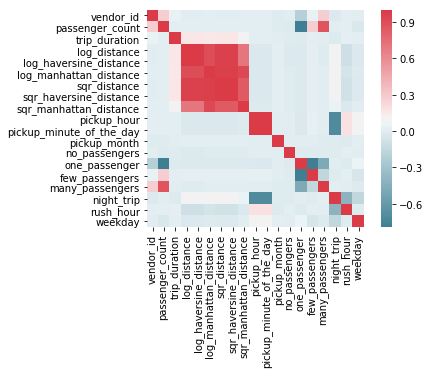

In [120]:
corr = proc_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)